# Spatial Data Assimilation in Geologic CO2 Sequestration
## Misael M. Morales - Summer 2023 - LANL

In [1]:
# Load packages, class, and functions
from utils import *
sda = spatialDA()
sda.check_torch_gpu()
#octave = sda.mrst_startup()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: Python39 | Python version: 3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]
Torch version: 2.0.0+cu117
Torch build with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080



True Perm: (2601,) | True Saturation: (3, 2601)
Perm Ensemble: (100, 2601) | Saturation Ensemble: (100, 3, 2601)
Perm All shape: (101, 2601)


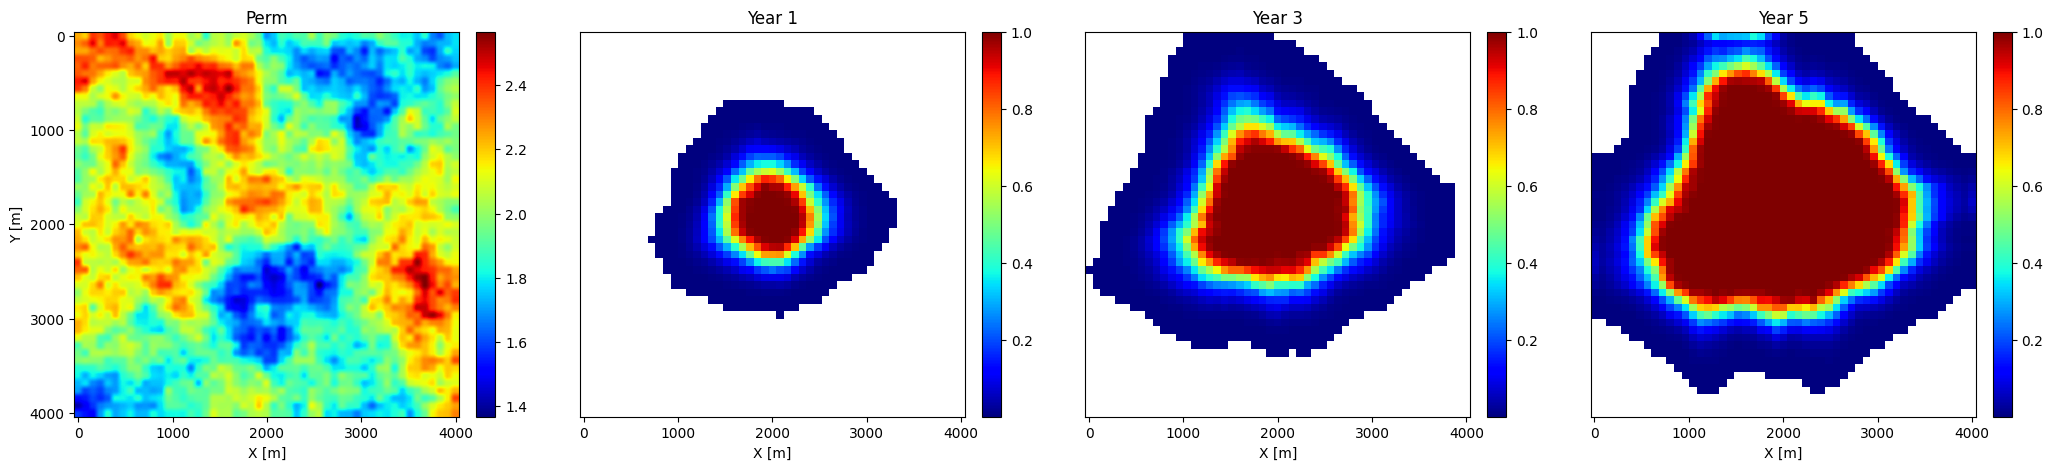

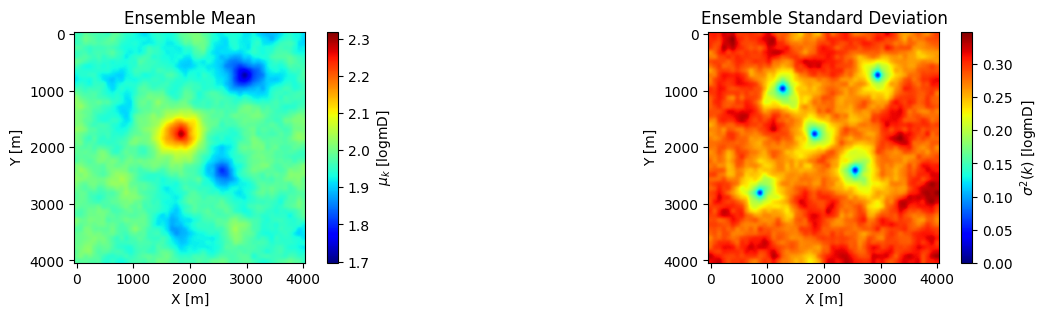

In [2]:
# Load permeability (true, ensemble) and saturation (true)
perm_true, sat_true = sda.load_perm_sat_true()
perm_ens,  sat_ens  = sda.load_perm_sat_ens()
perm_all            = sda.load_perm_all()
sat_true_bc         = np.load('true_sat_bc.npy')

sda.plot_perm_sat(perm_true, sat_true_bc)
sda.plot_ens_mean_std()

***
### ESMDA-GEO

In [188]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

true: (100, 2601) | predicted: (100, 2601)


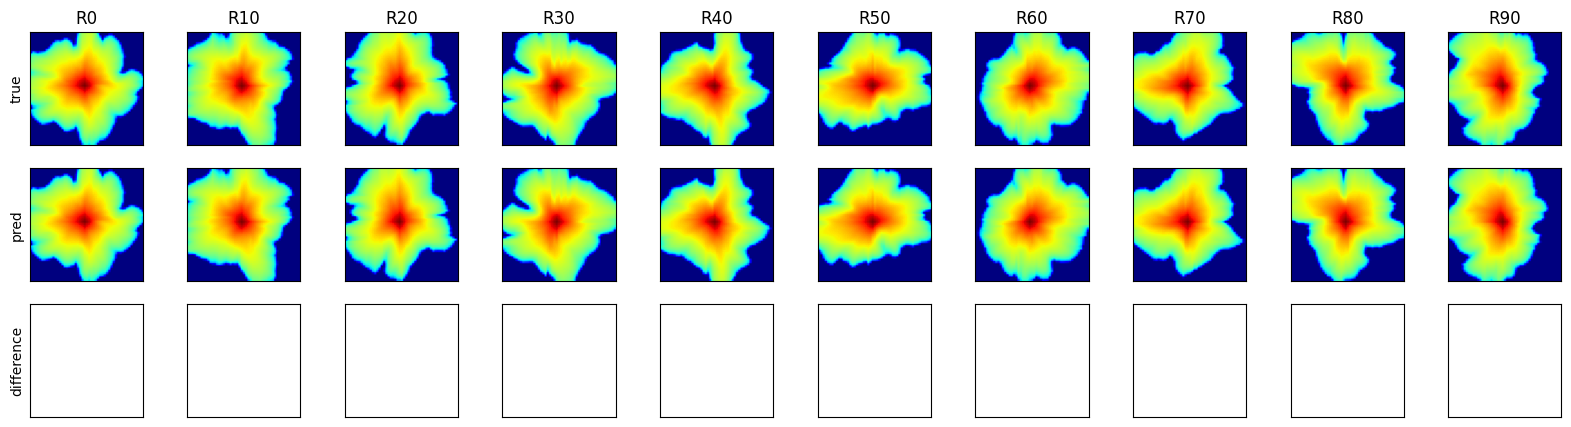

In [210]:
layer = 1
y_true = sat_ens[:,layer]

reg = DecisionTreeRegressor()
reg.fit(perm_ens, y_true)
y_pred = reg.predict(perm_ens)
print('true: {} | predicted: {}'.format(y_true.shape, y_pred.shape))

fig, axs = plt.subplots(3, 10, figsize=(20,5))
for i in range(10):
    k = i*10
    true, pred = y_true[k].reshape(51,51), y_pred[k].reshape(51,51)
    axs[0,i].imshow(true, 'jet'); axs[0,0].set(ylabel='true')
    axs[1,i].imshow(pred, 'jet'); axs[1,0].set(ylabel='pred')
    axs[2,i].imshow(np.abs(true-pred), cmap='binary'); axs[2,0].set(ylabel='difference')
    axs[0,i].set(title='R{}'.format(k))
    for j in range(3):
        axs[j,i].set(xticks=[], yticks=[])

In [229]:
# Ensemble
m_ensemble = perm_ens
print('m_ensemble: {}'.format(m_ensemble.shape))

# Observations
obs     = sat_true[layer]
cov_obs = approximate_cov_mm(m_ensemble)
print('obs: {} | cov_obs: {}'.format(obs.shape, cov_obs.shape))

n_assimilations = 4

# ESMDA
def forward_model(ens):
    return reg.predict(ens)
solver = ESMDA(obs=obs, m_init=m_ensemble, cov_obs=cov_obs, 
               forward_model             = forward_model,
               n_assimilations           = n_assimilations,
               save_ensembles_history    = True)
solver.solve()

m_ensemble: (100, 2601)
obs: (2601,) | cov_obs: (2601, 2601)
Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4


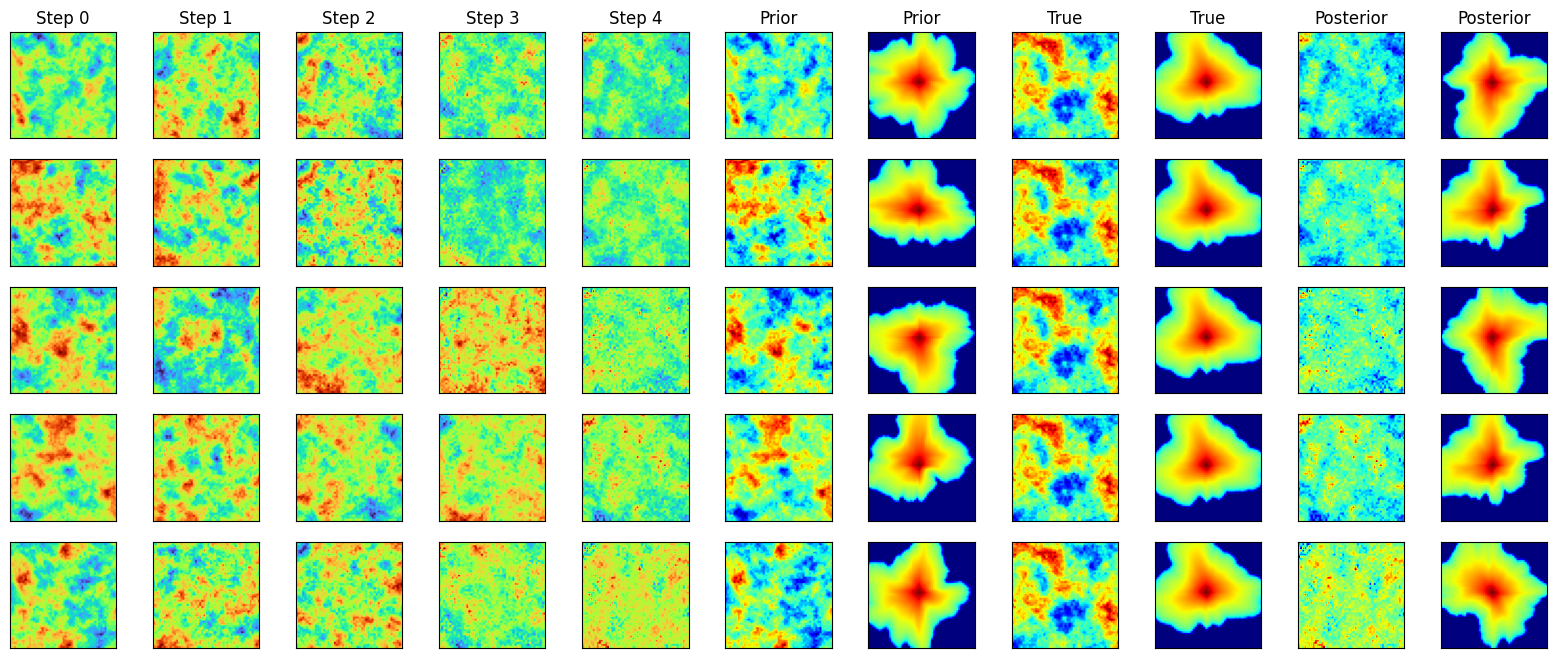

In [230]:
temp = np.array(solver.m_history)
n_steps = temp.shape[0]

fig, axs = plt.subplots(5, n_steps+6, figsize=(20,8))
for i in range(5):
    for j in range(n_steps):
        axs[i,j].imshow(temp[j,i].reshape(51,51), cmap='turbo'); axs[0,j].set(title='Step {}'.format(j))
    for j in range(n_steps+6):
        axs[i,j].set(xticks=[], yticks=[])

    axs[i,n_steps].imshow(perm_ens[i].reshape(51,51), 'jet'); axs[0,n_steps].set(title='Prior')
    axs[i,n_steps+1].imshow(sat_ens[i,layer].reshape(51,51), 'jet'); axs[0,n_steps+1].set(title='Prior')

    axs[i,n_steps+2].imshow(perm_true.reshape(51,51), 'jet'); axs[0,n_steps+2].set(title='True')
    axs[i,n_steps+3].imshow(sat_true[layer].reshape(51,51), 'jet'); axs[0,n_steps+3].set(title='True')

    axs[i,n_steps+4].imshow(solver.m_prior[i].reshape(51,51), 'jet'); axs[0,n_steps+4].set(title='Posterior')
    axs[i,n_steps+5].imshow(solver.d_pred[i].reshape(51,51), 'jet'); axs[0,n_steps+5].set(title='Posterior')

***
# END